In [39]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add current directory to path
sys.path.append(os.getcwd())

from Engine import Engine
from Options import Options
from GBMplot import plot_contour_over_seg, plot_grid_contour_overlay, plot_plan_comparison, plot_density_over_seg
from evaluate import evaluate_personalized_plan
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# 1. Configure Options
# We start with the default options and customize them for this tutorial
gbmopts = Options()

# Set input paths
# Using data_006 as in the previous example
input_dir = Path("../data/GLIODIL/data_034/")
gbmopts.opts['dataset_opts']['csf_file'] = input_dir/ "csf_pbmap.nii.gz"
gbmopts.opts['dataset_opts']['gm_file'] = input_dir/ "gm_pbmap.nii.gz"
gbmopts.opts['dataset_opts']['wm_file'] = input_dir/ "wm_pbmap.nii.gz"
gbmopts.opts['dataset_opts']['segpre_file'] = input_dir/ "tumor_seg.nii.gz"
gbmopts.opts['dataset_opts']['segrec_file'] = input_dir/ "recurrence_preop.nii.gz"
gbmopts.opts['dataset_opts']['brain_mask_file'] = input_dir/ "t1c_bet_mask.nii.gz"
gbmopts.opts['dataset_opts']['xdim'] = 3      # 3D simulation
z_vis = 72

# Logger configuration
gbmopts.opts['logger_opts']['use_stdout'] = True
gbmopts.opts['logger_opts']['use_mlflow'] = False
gbmopts.opts['logger_opts']['output_dir'] = ""

# Disable internal figure generation in Engine to show it manually here
gbmopts.opts['skip_fig'] = True 
gbmopts.opts['train_opts']['iter_init'] = 2000
gbmopts.opts['train_opts']['print_every'] = 100

# Reduce iterations for tutorial speed
gbmopts.process_options()

# Initialize Engine
engine = Engine(gbmopts.opts)

Using device: cuda
Artifacts will be saved to: /home/ziruz16/predictgbm/runs/dev/test


{'logger_opts': {'use_mlflow': False, 'use_stdout': True, 'experiment_name': 'dev', 'run_name': 'test', 'use_tmp': False, 'output_dir': ''}, 'dataset_opts': {'input_dir': '', 'segpre_file': PosixPath('../data/GLIODIL/data_034/tumor_seg.nii.gz'), 'gm_file': PosixPath('../data/GLIODIL/data_034/gm_pbmap.nii.gz'), 'wm_file': PosixPath('../data/GLIODIL/data_034/wm_pbmap.nii.gz'), 'csf_file': PosixPath('../data/GLIODIL/data_034/csf_pbmap.nii.gz'), 'segrec_file': PosixPath('../data/GLIODIL/data_034/recurrence_preop.nii.gz'), 'brain_mask_file': PosixPath('../data/GLIODIL/data_034/t1c_bet_mask.nii.gz'), 'z_slice': -1, 'xdim': 3}, 'restore': '', 'traintype': 'full', 'skip_dataset': False, 'skip_fig': True, 'flags': [], 'device': 'cuda', 'seed': 0, 'pde_opts': {'factor': 10.0, 'datafile': '', 'h_init': 0.5, 'r_init': 0.01, 'trainable_param': ['rD', 'rRHO', 'th1', 'th2'], 'init_param': {}, 'whichdata': 'pat', '

In [30]:
# 2. Run Pre-processing
# This step loads data, computes phase field, estimates characteristic parameters, 
# and generates the initial dataset (training data for initialization)
engine.run_pre()

Preprocessing
Phase Field Solver using device: cuda
Saved phase field to /home/ziruz16/predictgbm/runs/dev/test/phi.mat
Estimating Char Params


{'Dc': 0.30000000000000004, 'rhoc': 0.01, 'L': 30, 'T': 547.7225575051662, 'r_wt_sim': 38.0, 'r_tc_sim': 18.0, 'error': None, 'r_wt_data': 29.982010406538503, 'r_tc_data': 20.222263173298135, 'score': 0.3773042422223455, 'x0': array([126.07806005,  99.55837182,  79.67355658])}
Solve FKPP with char param
Solve FKPP using device: cuda
Starting simulation (PyTorch). tfinal=547.7225575051662, dt=5.4970e-01
Evaluation char: {'std_ctv_vol': 218102, 'my_ctv_vol': 219208, 'threshold': 0.13758203125, 'my_ctv_eff': 0.999421965317919, 'std_ctv_eff': 0.9416184971098266, 'dice_wt': 0.6988761059108674, 'dice_tc': 0.7646378575776019}


{'std_ctv_vol': 218102, 'my_ctv_vol_char': 219208, 'threshold_char': 0.13758203125, 'my_ctv_eff_char': 0.999421965317919, 'std_ctv_eff': 0.9416184971098266, 'dice_wt_char': 0.6988761059108674, 'dice_tc_char': 0.764637857577601

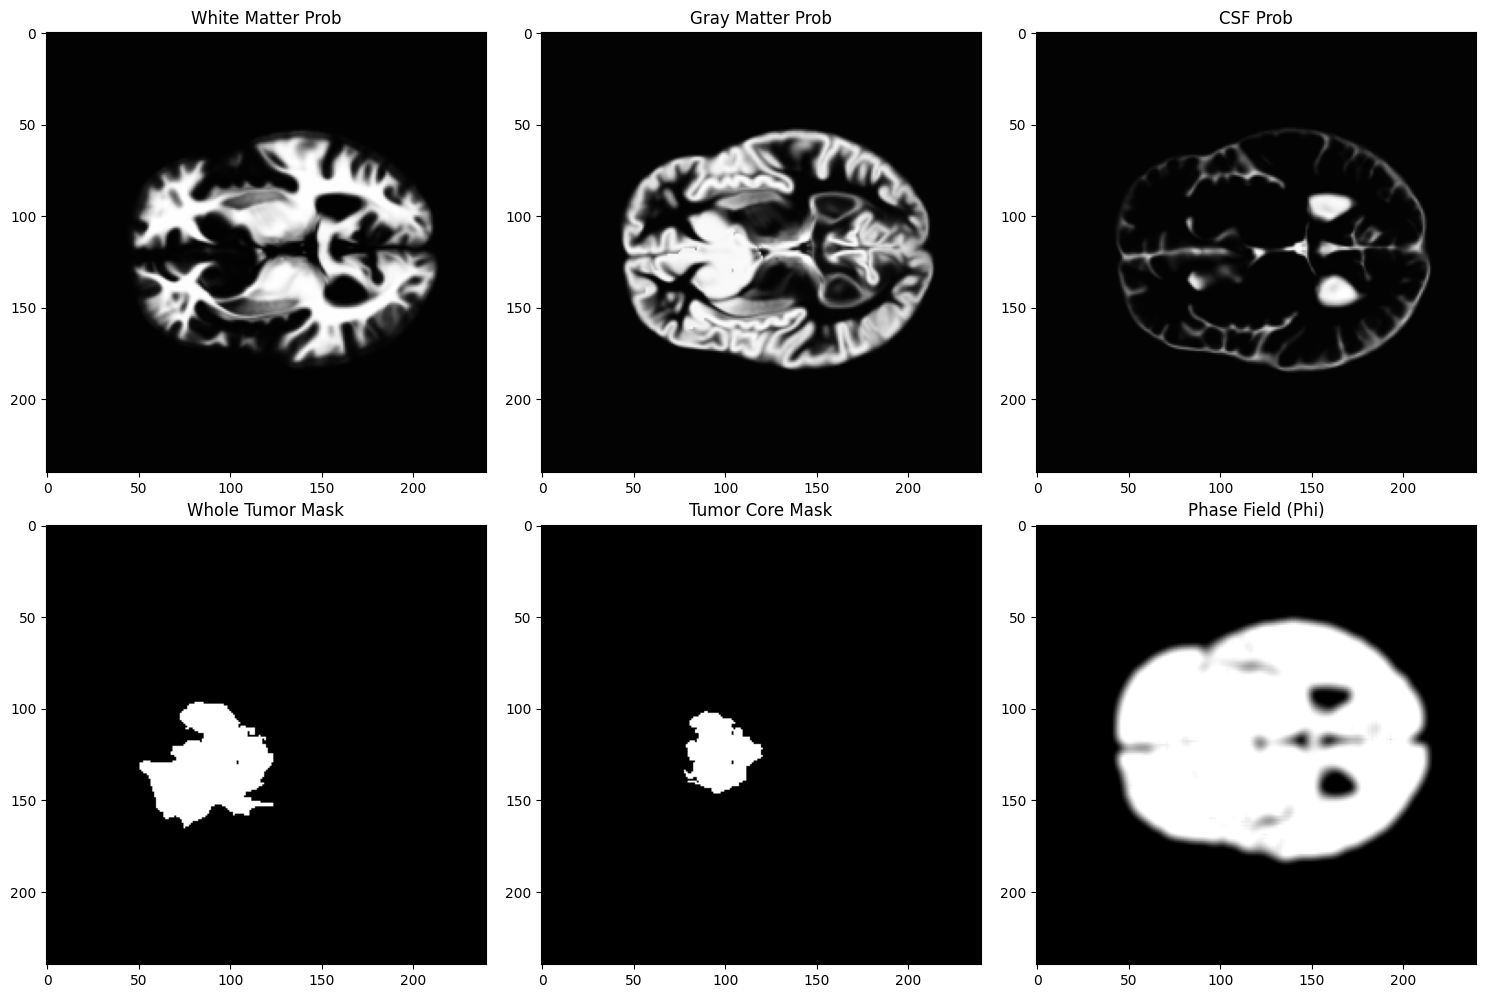

In [31]:
# Visualize Preprocessed Data and Phase Field
pdata = engine.pdata

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(pdata['Pwm'][:, :, z_vis], cmap='gray', origin='lower')
axes[0, 0].set_title('White Matter Prob')

axes[0, 1].imshow(pdata['Pgm'][:, :, z_vis], cmap='gray', origin='lower')
axes[0, 1].set_title('Gray Matter Prob')

axes[0, 2].imshow(pdata['Pcsf'][:, :, z_vis], cmap='gray', origin='lower')
axes[0, 2].set_title('CSF Prob')

axes[1, 0].imshow(pdata['mask_wt'][:, :, z_vis], cmap='gray', origin='lower')
axes[1, 0].set_title('Whole Tumor Mask')

axes[1, 1].imshow(pdata['mask_tc'][:, :, z_vis], cmap='gray', origin='lower')
axes[1, 1].set_title('Tumor Core Mask')

axes[1, 2].imshow(pdata['phi'][:, :, z_vis], cmap='gray', origin='lower')
axes[1, 2].set_title('Phase Field (Phi)')

for ax in axes.flat:
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

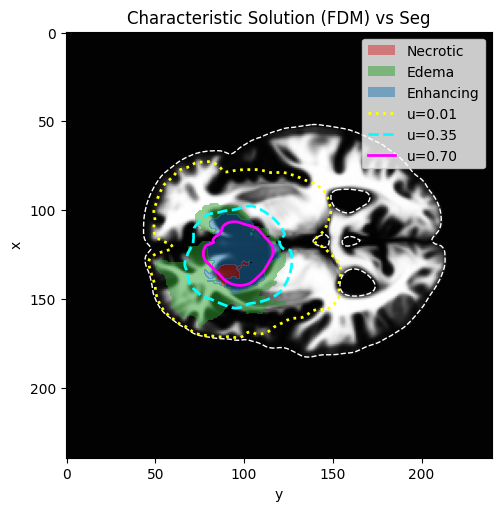

In [32]:
# Visualize Characteristic Solution
# Specifically, we visualize the FDM simulation result using the estimated parameters
# This is stored in engine.vdict['char_fdm'] during run_pre()

# Get the last time step of the characteristic solution
char_u = engine.vdict['char_fdm'][..., -1]
thresholds = [engine.char_params['th1'], engine.char_params['th2']]

plot_contour_over_seg(
    char_u[:, :, z_vis],
    thresholds=thresholds,
    seg=pdata['seg'][:, :, z_vis],
    bg=pdata['Pwm'][:, :, z_vis],
    phi=pdata['phi'][:, :, z_vis],
    title="Characteristic Solution (FDM) vs Seg"
)
plt.show()

In [33]:
# adsfasdfd3. Run Initialization
# Pre-training the Neural Network to match the characteristic solution
# No visualization requested for this step
engine.run_init()

convert dataset to torch
move dataset to cuda
convert dataset to torch

[Step 0] res=0.003109 uchar_res=0.023401 total=0.237121 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000

/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(



[Step 100] res=0.000298 uchar_res=0.000287 total=0.003166 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 200] res=0.000295 uchar_res=0.000203 total=0.002323 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 300] res=0.000293 uchar_res=0.000162 total=0.001909 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 400] res=0.000287 uchar_res=0.000138 total=0.001668 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 500] res=0.000280 uchar_res=0.000125 total=0.001528 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 600] res=0.000273 uchar_res=0.000116 total=0.001437 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 700] res=0.000268 uchar_res=0.000110 total=0.001372 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 800] res=0.000263 uchar_res=0.000106 total=0.001324 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 900] res=0.000260 uchar_res=0.000103 total=0.001286 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 100

In [34]:
# 4. Run Inverse Problem
# Fine-tuning the Neural Network and estimating parameters to match patient segmentation
engine.run_inv()

Using datafile: /home/ziruz16/predictgbm/runs/dev/test/dat.mat
convert dataset to torch
move dataset to cuda
convert dataset to torch

[Step 2000] res=0.000241 seg1=0.460864 seg2=0.314731 rD_reg=0.000000 rRHO_reg=0.000000 th1_reg=0.000000 th2_reg=0.000000 total=0.000249 rD=1.000000 rRHO=1.000000 th1=0.350000 th2=0.700000
[Step 2100] res=0.000183 seg1=0.443306 seg2=0.342320 rD_reg=0.006694 rRHO_reg=0.005396 th1_reg=0.000000 th2_reg=0.000010 total=0.000203 rD=0.918185 rRHO=0.926540 th1=0.350681 th2=0.696789
[Step 2200] res=0.000168 seg1=0.433364 seg2=0.325235 rD_reg=0.015228 rRHO_reg=0.006222 th1_reg=0.000002 th2_reg=0.000003 total=0.000197 rD=0.876597 rRHO=0.921120 th1=0.351245 th2=0.698253
[Step 2300] res=0.000163 seg1=0.426864 seg2=0.314462 rD_reg=0.018973 rRHO_reg=0.005989 th1_reg=0.000002 th2_reg=0.000001 total=0.000195 rD=0.862258 rRHO=0.922612 th1=0.351471 th2=0.698904
[Step 2400] res=0.000161 seg1=0.421683 seg2=0.307955 rD_reg=0.020001 rRHO_reg=0.005874 th1_reg=0.000002 th2_reg=0

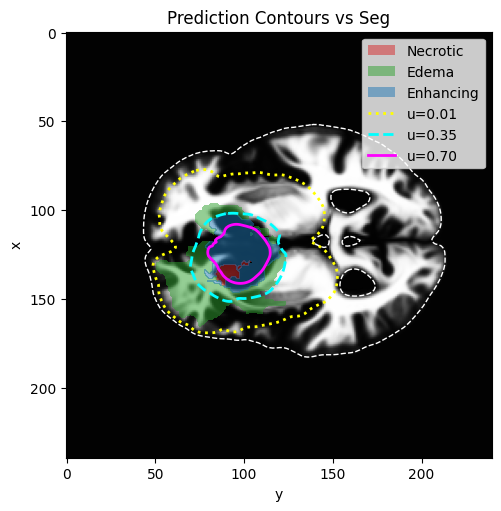

In [44]:
# 5. Visualize and Evaluate
# Get prediction and parameters
pred = engine.vdict['upred_fdm'][..., -1]
th1 = engine.pde.dataset['th1_pred']
th2 = engine.pde.dataset['th2_pred']

# Calculate plans and metrics to get the CTV threshold
metrics, plans = evaluate_personalized_plan(
    segmentation=engine.pdata['mask_tc'],
    brain_mask=engine.pdata['brain_mask'],
    predicted_density=pred,
    recurrence_mask=engine.pdata.get('mask_rec', None),
    ctv_margin=15
)

# Use the calculated CTV threshold for visualization
ctv_threshold = metrics['threshold']
thresholds = [th1, th2]

# 1. Contour Plot
plot_contour_over_seg(
    pred[:, :, z_vis],
    thresholds=thresholds,
    seg=engine.pdata['seg'][:, :, z_vis],
    bg=engine.pdata['Pwm'][:, :, z_vis],
    phi=engine.pdata['phi'][:, :, z_vis],
    title="Prediction Contours vs Seg"
)
plt.show()

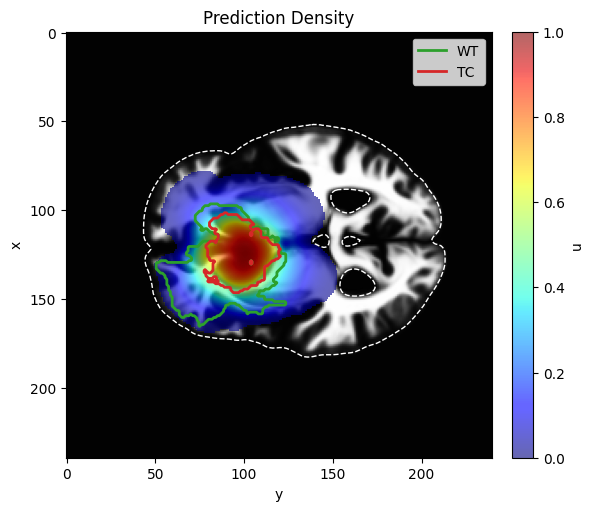

In [41]:
# 2. Density Plot
plot_density_over_seg(
    pred[:, :, z_vis],
    u1=engine.pdata['mask_wt'][:, :, z_vis],
    u2=engine.pdata['mask_tc'][:, :, z_vis],
    bg=engine.pdata['Pwm'][:, :, z_vis],
    phi=engine.pdata['phi'][:, :, z_vis],
    title="Prediction Density"
)
plt.show()

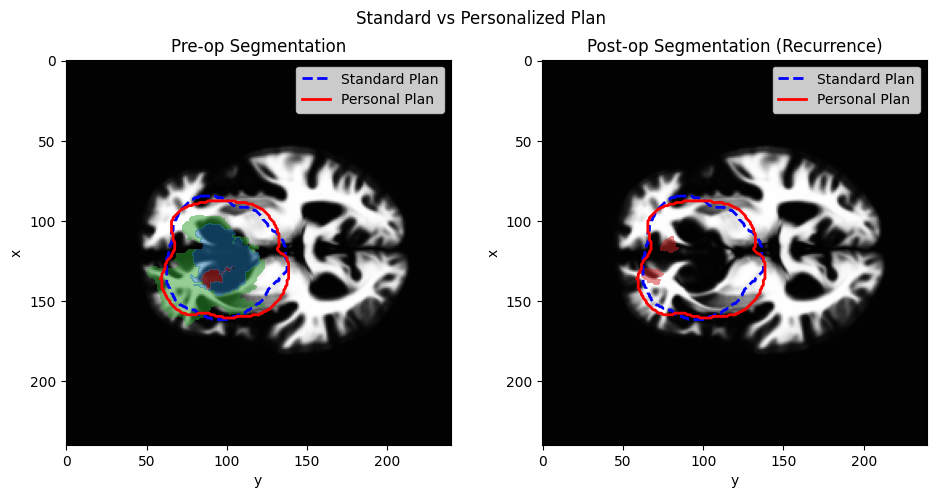

Evaluation Metrics: {'std_ctv_vol': 218102, 'my_ctv_vol': 219495, 'threshold': 0.08294921875, 'my_ctv_eff': 0.9988439306358381, 'std_ctv_eff': 0.9416184971098266}


In [42]:
# 3. Plan Comparison
# Compare Standard Plan vs Personalized Plan
# The Personalized Plan uses the predicted CTV threshold

seg_rec_slice = engine.pdata.get('mask_rec')
if seg_rec_slice is not None:
    seg_rec_slice = seg_rec_slice[:, :, z_vis]

plot_plan_comparison(
    plans['standard_plan'][:, :, z_vis],
    plans['personal_plan'][:, :, z_vis],
    seg_pre=engine.pdata['seg'][:, :, z_vis],
    seg_post=seg_rec_slice, 
    bg=engine.pdata['Pwm'][:, :, z_vis],
    title="Standard vs Personalized Plan"
)
plt.show()

print("Evaluation Metrics:", metrics)